In [1]:
import pyLDT_cosmo
import numpy as np
import matplotlib.pyplot as plt
import os

print('Using pyLDT-cosmo %s installed at %s'%(pyLDT_cosmo.__version__,os.path.dirname(pyLDT_cosmo.__file__)))

Using pyLDT-cosmo 0.4.10 installed at /Users/matteoc/Documents/Projects/MG_PDF/codes/pyLDT/pyLDT_cosmo


In [2]:
# Set fiducial LCDM cosmology; if changed, also update non-linear variances below
cosmo_params_fid = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37}
# Output redshifts and smoothing radii. If different/more are wanted, must adjust non-linear variance matrix below accordingly
z = [0., 0.5, 1.] # output redshifts
R = [10., 15., 20.] # radius of top-hat smoothing filter in Mpc/h
######## Non-linear variances for mu = log(rho) in fiducial LCDM cosmology ########
# The matrix s2_mu_lcdm_fid[i,j] gives non-linear variances for smoothing radius R[i] and redshift z[j]
# Only fiducial LCDM values are needed: corresponding values for MG/DE and other LCDM cosmologies can be 
# accurately derived (<0.2%) using Eq. 14 in 1911.11158
s2_mu_fid = np.array([[0.391930, 0.252758, 0.166748], 
                      [0.232552, 0.144374, 0.092990], 
                      [0.149381, 0.090940, 0.057913]]) # update this if new redshifts and/or radii available, or if changing fiducial cosmology
# Initialise matter PDF object
mPDF = pyLDT_cosmo.pyLDT.matter_pdf(cosmo_params_fid, z, R, s2_mu_fid)

In [3]:
# Set cosmological parameters
cosmo_params = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37, 'w0': -0.8, 'wa': 0., 'fR0': -1e-5, 'n': 1., 'rcH0': 0.5}
# Select any combination of models between 'lcdm', 'wcdm', 'fr' and 'dgp'
models = ['lcdm', 'wcdm', 'fr', 'dgp'] 
# Compute matter PDF for requested models
pdf_mat = mPDF.compute_pdf(cosmo_params, models)

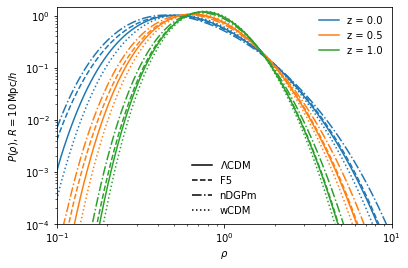

In [4]:
# plot PDFs for various redshifts
rho = np.logspace(-1,1,100)

plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $R = 10 \, {\rm Mpc}/h$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(z))]
for i in range(len(z)):
    line[i], = plt.plot(rho,pdf_mat['lcdm'][0][i](rho), color='C'+str(i), label='z = '+str(z[i]))
    plt.plot(rho,pdf_mat['fr'][0][i](rho), color='C'+str(i), linestyle='dashed')
    plt.plot(rho,pdf_mat['dgp'][0][i](rho), color='C'+str(i), linestyle='dashdot')
    plt.plot(rho,pdf_mat['wcdm'][0][i](rho), color='C'+str(i), linestyle='dotted')
z_legend = plt.legend(handles=line, loc="best", frameon=False)
ax = plt.gca().add_artist(z_legend)
lcdm_style, = plt.plot(rho,np.zeros(rho.shape), color='k', label='$\Lambda$CDM')
fr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashed', label='F5')
dgp_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashdot', label='nDGPm')
wcdm_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dotted', label='wCDM')
plt.legend(handles=[lcdm_style,fr_style,dgp_style,wcdm_style], loc='lower center', frameon=False)

plt.show()

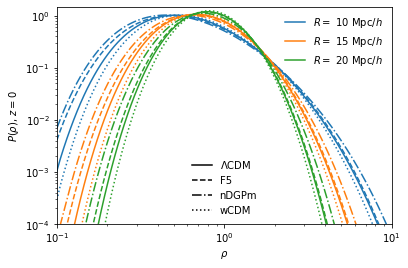

In [5]:
# plot PDFs for various smoothing radii
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $z = 0$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(R))]
for i in range(len(R)):
    line[i], = plt.plot(rho,pdf_mat['lcdm'][i][0](rho), color='C'+str(i), label=r'$R =$ '+str(int(R[i]))+r' Mpc/$h$')
    plt.plot(rho,pdf_mat['fr'][i][0](rho), color='C'+str(i), linestyle='dashed')
    plt.plot(rho,pdf_mat['dgp'][i][0](rho), color='C'+str(i), linestyle='dashdot')
    plt.plot(rho,pdf_mat['wcdm'][i][0](rho), color='C'+str(i), linestyle='dotted')
R_legend = plt.legend(handles=line, loc='upper right', frameon=False)
ax = plt.gca().add_artist(R_legend)
lcdm_style, = plt.plot(rho,np.zeros(rho.shape), color='k', label='$\Lambda$CDM')
fr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashed', label=r'F5')
dgp_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashdot', label='nDGPm')
wcdm_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dotted', label='wCDM')
plt.legend(handles=[lcdm_style,fr_style,dgp_style,wcdm_style], loc='lower center', frameon=False)

plt.show()

In [7]:
# Example PDFs computed using sigma2_mu extracted from Durham simulations
# Set cosmology
cosmo_F5 = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37, 'fR0': -1e-5, 'n': 1.}
# Define matrix with non-linear variances
s2_mu_F5 = np.array([[0.428094, 0.266596, 0.171300],
                     [0.248303, 0.149669, 0.094536],
                     [0.156913, 0.093303, 0.058560]])
# Compute linear Pk for LCDM cosmology
sig2_lcdm, kvec, pk = mPDF.sigma2_lcdm(cosmo_params_fid)
# Compute linear variances for f(R) gravity cosmology
sig2_F5 = mPDF.sigma2_fr(cosmo_F5, kvec, pk)
# Compute PDFs using simulation extracted non-linear variances
sim_pdf_mat_F5 = mPDF.get_pdf(s2_mu_F5, sig2_F5)

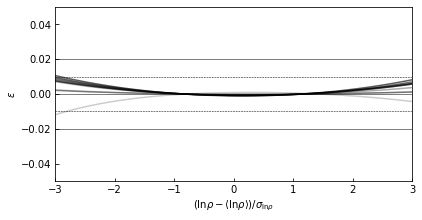

In [16]:
# Fractional difference between the PDFs computed with the log-normal approximation and those obtained from the simulation extracted NL variances
rho = np.logspace(-1,1,100)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[6.4,3.2])
fig.subplots_adjust(hspace=0)
axs.set_xlabel(r"$(\ln\rho - \langle \ln\rho \rangle)/\sigma_{\ln\rho}$")

axs.set_xlim(-3,3)
axs.set_ylim(-0.05,0.05)
axs.tick_params(axis='both', which='both', direction='in')
axs.hlines([-0.02,0,0.02], xmin=-3, xmax=3, colors='k',lw=0.5)
axs.hlines([-0.01,0.01], xmin=-3, xmax=3, colors='k',lw=0.5, ls='--')
axs.set_ylabel(r"$\epsilon$")

alpha = np.linspace(0.2,0.7,9)
alpha_ix = 0
# Matrix with log(rho) means for the F5 cosmology defined above. Used only for plotting purposes
mean_mu_F5 = np.array([[-0.222616, -0.135667, -0.085745],
                       [-0.125848, -0.075427, -0.047504],
                       [-0.078012, -0.046139, -0.028762]])

for R_ix, R_data in enumerate(R):    
    for z_ix, z_data in enumerate(z):    

        norm_logrho = (np.log(rho) - mean_mu_F5[R_ix][z_ix])/np.sqrt(s2_mu_F5[R_ix][z_ix])

        ratio = pdf_mat['fr'][R_ix][z_ix](rho)/sim_pdf_mat_F5[R_ix][z_ix](rho)
        axs.plot(norm_logrho, ratio - 1, color='k', alpha=alpha[alpha_ix])

        alpha_ix += 1

plt.show()